In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!pip install torch torchvision torchaudio
!pip install albumentations==1.4.3
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 2.0.8
    Uninstalling albumentations-2.0.8:
      Successfully uninstalled albumentations-2.0.8


In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [3]:
class CocoMaskedDataset(Dataset):
    def __init__(self, images_path, annotations_path, transform=None):
        self.images_path = images_path
        self.coco = COCO(annotations_path)
        self.img_ids = self.coco.getImgIds()
        self.transform = transform

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.images_path, img_info['file_name'])
        img = np.array(Image.open(img_path).convert("RGB"))
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        mask = np.zeros(img.shape[:2], dtype=np.uint8)
        for ann in anns:
            m = self.coco.annToMask(ann)
            mask = np.maximum(mask, m)
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"]
        else:
            img = ToTensorV2()(image=img)["image"]
            mask = torch.tensor(mask, dtype=torch.uint8)

        masked_img = img.clone()
        masked_img[:, mask == 0] = 0
        return img, masked_img

In [4]:
transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomRotate90(p=0.5),
    A.ColorJitter(p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [11]:
images_path = "/content/drive/MyDrive/Colab Notebooks/Vision Extract/val2017"
annotations_path = "/content/drive/MyDrive/Colab Notebooks/Vision Extract/val2017/annotations/instances_val2017.json"

dataset = CocoMaskedDataset(images_path, annotations_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

loading annotations into memory...
Done (t=1.68s)
creating index...
index created!


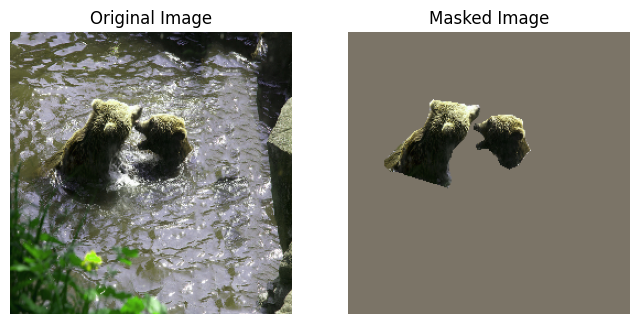

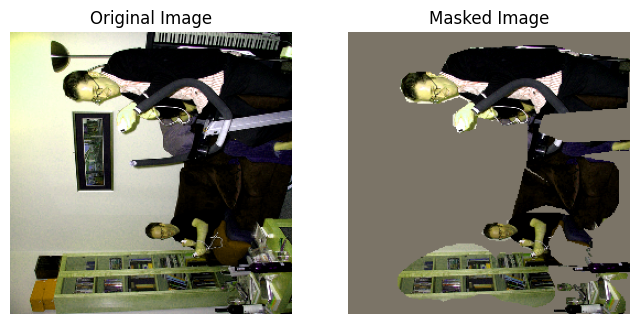

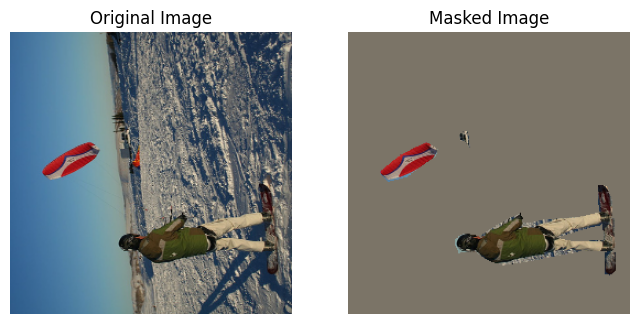

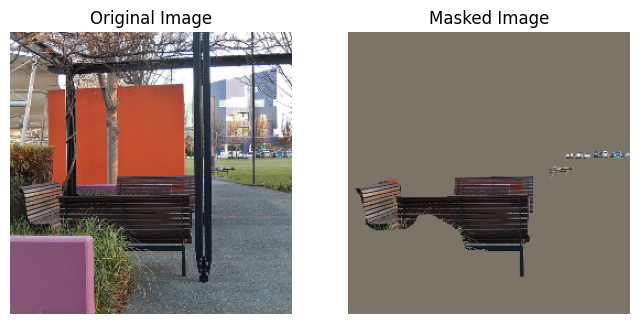

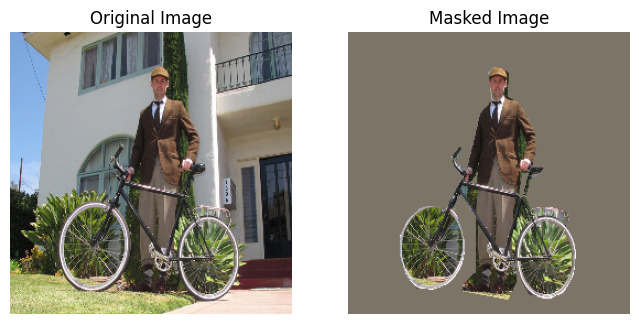

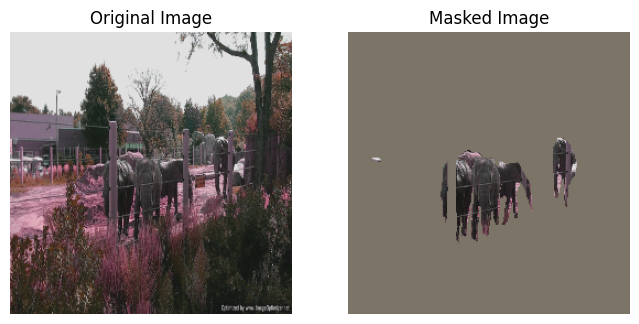

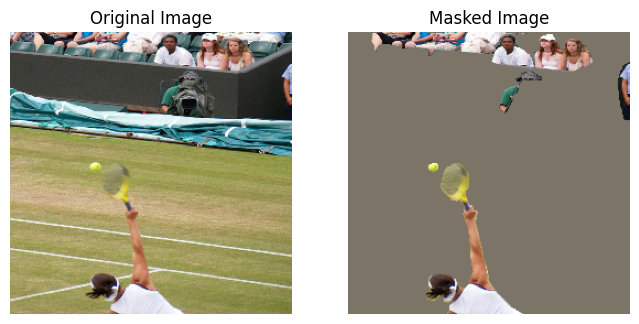

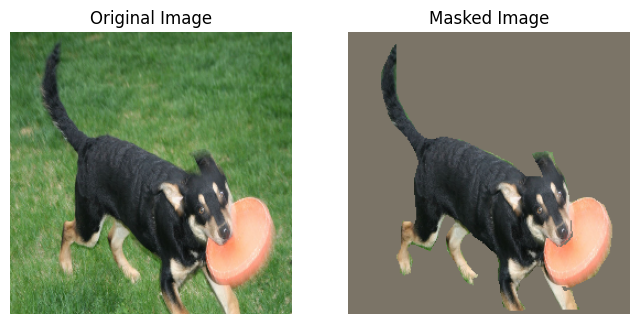

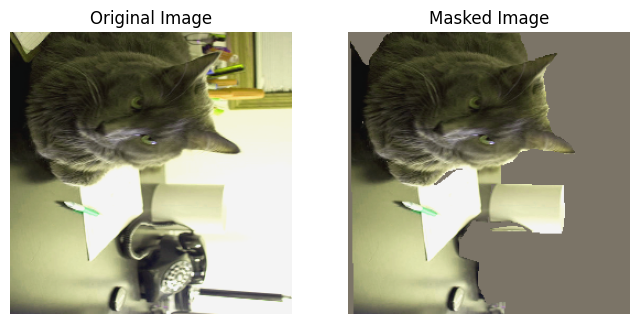

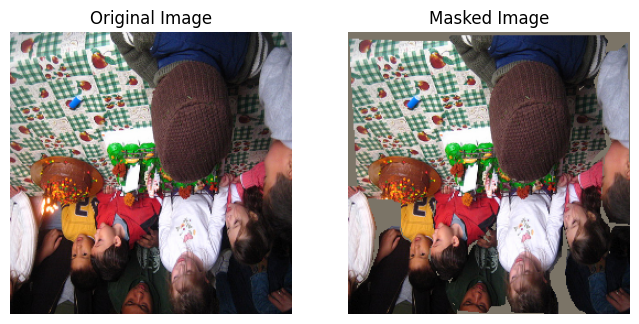

In [12]:
import matplotlib.pyplot as plt
import numpy as np

for orig_batch, masked_batch in dataloader:
    for i in range(orig_batch.size(0)):

        orig_img = orig_batch[i].cpu().numpy()
        if orig_img.shape[0] in [1, 3]:   # [C, H, W] → [H, W, C]
            orig_img = np.transpose(orig_img, (1, 2, 0))
        orig_img = (orig_img * std + mean).clip(0, 1)


        masked_img = masked_batch[i].cpu().numpy()
        if masked_img.shape[0] in [1, 3]:
            masked_img = np.transpose(masked_img, (1, 2, 0))
        masked_img = (masked_img * std + mean).clip(0, 1)


        masked_img = np.where(masked_img <= 0.01, 0, masked_img)


        plt.figure(figsize=(8, 4))

        plt.subplot(1, 2, 1)
        plt.imshow(orig_img)
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(masked_img)
        plt.title("Masked Image")
        plt.axis("off")

        plt.show()
    break
